In [ ]:
#@title [RUN] Install required libraries

!pip install torch==2.0.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install networkx

!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric==2.3.0

!pip install -q rdkit-pypi
!pip install -q py3Dmol

Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [ ]:
#@title [RUN] Import python modules


import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.0.0+cu118
PyG version 2.3.0


In [ ]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [ ]:
#@title [RUN] Helper functions for data preparation

class SetTarget(object):
    """
    This transform mofifies the labels vector per data sample to only keep
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target
        data.y = data.y[:, target]
        return data


class CompleteGraph(object):
    """
    This transform adds all pairwise edges into the edge index per data sample,
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device) # Create tensor (0,...,len(data.num_nodes) - 1)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device) # Create tensor (0,...,len(data.num_nodes) - 1)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1) # Creates tensor (0, 0, 0, ..., len(data.num_nodes) - 1, len(data.num_nodes) - 1)
        col = col.repeat(data.num_nodes) # Creates tensor (0, 1, 2, ..., len(data.num_nodes) - 2, len(data.num_nodes) - 1)
        edge_index = torch.stack([row, col], dim=0) # Merges row and col into one tensor

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

In [ ]:
#@title [RUN] Helper functions for visualization

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H",
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())] # Given our allowable_atoms we now can return which one in
    except:                                     # our list has the highest probability which is encoded in t
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

In [ ]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    path = './qm9'
    target = 0

    # Transforms which are applied during data loading:
    # (1) Fully connect the graphs, (2) Select the target/label
    transform = T.Compose([CompleteGraph(), SetTarget()])

    # Load the QM9 dataset with the transforms defined
    dataset = QM9(path, transform=transform)

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


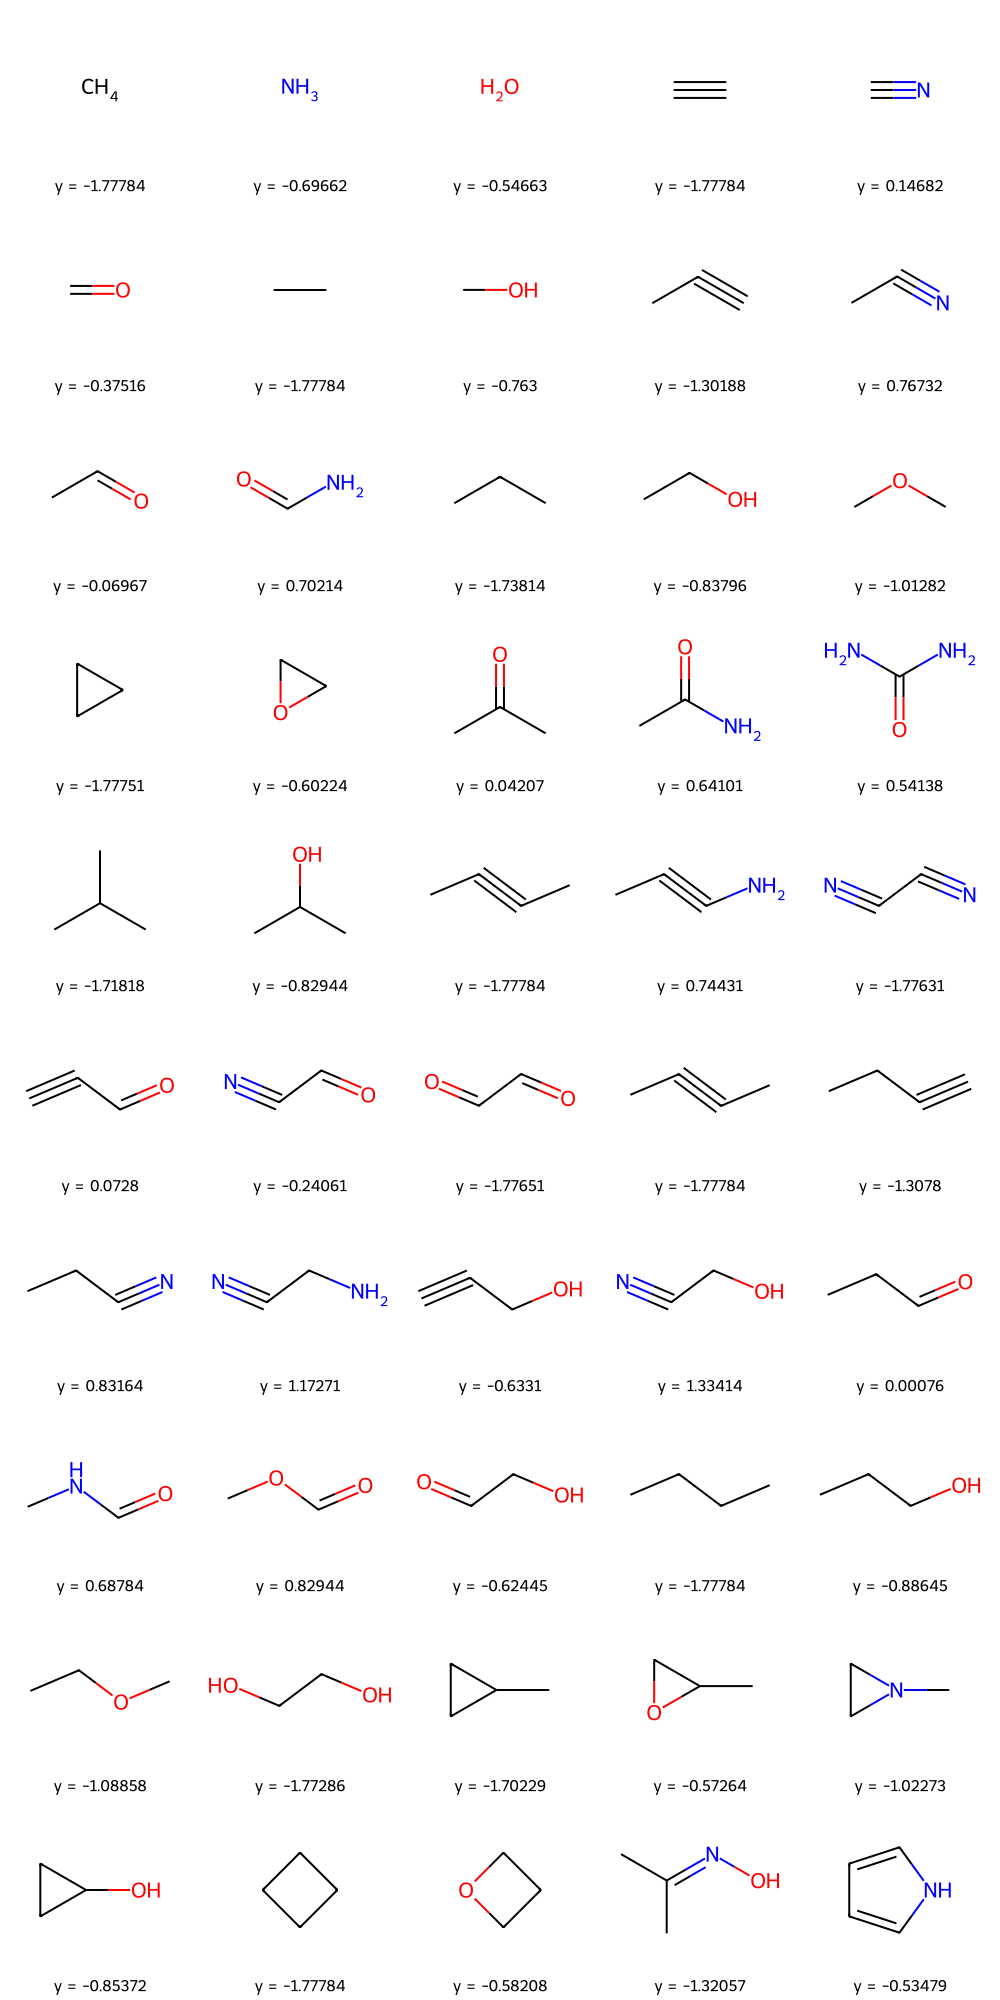

In [ ]:
num_viz = 50
mols = [to_rdkit(train_dataset[i]) for i in range(num_viz)]
values = [str(round(float(train_dataset[i].y), 5)) for i in range(num_viz)]

Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

In [ ]:
data = [train_dataset[i] for i in range(3)] # one data sample, i.e. molecular graph
print("We print all the attributes (along with their shapes) that our PyG molecular graph contains for CH_4, NH_3 and H_2O:")
print(data)

We print all the attributes (along with their shapes) that our PyG molecular graph contains for CH_4, NH_3 and H_2O:
[Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 4], y=[1], pos=[5, 3], z=[5], name='gdb_1', idx=[1]), Data(x=[4, 11], edge_index=[2, 12], edge_attr=[12, 4], y=[1], pos=[4, 3], z=[4], name='gdb_2', idx=[1]), Data(x=[3, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1], pos=[3, 3], z=[3], name='gdb_3', idx=[1])]


In [ ]:
'''Here we represent all the node features in the CH_4 molecule. Each node has an 11-d feature vector
   Features 1-5: One-hot encoding of being either (H, C, N, O, F) atom
   Feature 6: Atomic number
   Feature 7: Aromatic (binary)
   Features 8-10: One-hot encoding of orbital hybridization (sp, sp2, sp3)
   Feature 11: Number of Hydrogen atoms attached'''

print(data[0].x)

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


In [ ]:
'''Here we represent the edge attribute features of CH_4. Each edge is one hot encoded to be a specific type of bond - (single, double, triple, aromatic)'''

print(data[0].edge_attr[1])

tensor([1., 0., 0., 0.])


In [ ]:
'''Here we also note that we have a geometric feature, this being the atom positions in space. We show these for CH_4.'''

print(data[0].pos)
print(torch.cat([data[0].x, data[0].pos], dim=1))

tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          6.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0000e+00, -1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0117e+00,  1.4638e+00,  3.0000e-04],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0

We do note that we have fully connected our atoms in each molecule so that our graph is full connected and undirected. So we note that we will have physical edges (bonds which actually exist) and non-physical edges (aren't present in real molecule as a bond). We however do still have information in the edge_attr feature vector as if no physical bond exists, all entries will be zero. We will later discuss the pros and cons of this method.


In [ ]:
print(f"\nThis molecule has {data[0].x.shape[0]} atoms, and {data[0].edge_attr.shape[0]} edges.")

print(f"\nFor each atom, we are given a feature vector with {data[0].x.shape[1]} entries (described above).")

print(f"\nFor each edge, we are given a feature vector with {data[0].edge_attr.shape[1]} entries (also described above).")

print(f"\nIn the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.")

print(f"\nEach atom also has a {data[0].pos.shape[1]}-dimensional coordinate associated with it. We will talk about their importance later in the practical.")

print(f"\nFinally, we have {data[0].y.shape[0]} regression target for the entire molecule.")


This molecule has 5 atoms, and 20 edges.

For each atom, we are given a feature vector with 11 entries (described above).

For each edge, we are given a feature vector with 4 entries (also described above).

In the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.

Each atom also has a 3-dimensional coordinate associated with it. We will talk about their importance later in the practical.

Finally, we have 1 regression target for the entire molecule.


In [ ]:
# Toy graph 1
edge_index_1 = torch.tensor(
    [[0, 1, 1, 2], [1, 0, 2, 1]],
    dtype=torch.long
)
x_1 = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data_1 = Data(x=x_1, edge_index=edge_index_1)

# Toy graph 2
edge_index_2 = torch.tensor(
    [[0, 2, 1, 0], [2, 0, 0, 1]],
    dtype=torch.long
)
x_2 = torch.tensor([[1], [0], [-1]], dtype=torch.float)

data_2 = Data(x=x_2, edge_index=edge_index_2)

# Create batch from toy graphs
data_list = [data_1, data_2]
batch = Batch.from_data_list(data_list)

assert (batch[0].x == data_1.x).all() and (batch[1].x == data_2.x).all()

# Create DataLoader
loader = DataLoader(data_list, batch_size=1, shuffle=False)
it = iter(loader)
batch_1 = next(it)
batch_2 = next(it)

assert (batch_1.x == data_1.x).all() and (batch_2.x == data_2.x).all()

In [ ]:
#@title Standard MPNN Layer

class MPNNLayer(MessagePassing):
  def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
    """
    MPNN Layer

    Args:
        emb_dim: (int) --> hidden dimensions = d
        edge_dim: (int) --> edge feature dimension = d_e
        aggr: (str) --> aggregation function = \oplus (sum/mean/max)
    """

    # Now we actually set up our aggregation function
    super().__init__(aggr=aggr)

    self.emb_dim = emb_dim
    self.edge_dim = edge_dim

    # MLP `\Psi` for computing messages `m_ij`
    # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
    # dims: (2d + d_e) -> d
    self.mlp_msg = Sequential(
        Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
        Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
      )

    # Multiple Layer Perceptron (MLP) = \Phi --> used for computing the message
    # from one node to the other
    # Implemented as a stack of Linear -> BN -> ReLU -> Linear -> BN -> ReLU
    # dims: (2d + d_e) --> d
    self.mlp_upd = Sequential(
        Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
        Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
    )

  def forward(self, h, edge_index, edge_attr):
    """
    The forward pass updates node features 'h' via one round of message passing.

    As our MPNNLayer class inherits from the PyG MessagePassing parent class,
    we need to call the 'propagate()'
    function which starts the message passing procedure:
    'message()' -> 'aggregate()' -> 'update()'.

    The MessagePassing class handles most of the logic for the implementation.
    To build custom GNNs, we only need to define our own 'message()',
    'aggregate()' and 'update()' functions (defined subseuently).

    Args:
        h: (n, d) --> initial node features
        edge_index: (e, 2) --> pairs of edges (i, j)
        edge_attr: (e, d_e) --> edge features

    Returns:
        out: (n, d) --> updated node features
    """
    out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
    return out

  def message(self, h_i, h_j, edge_attr):
    """
    Step 1: Message

    The 'message()' function constructs messages from source nojes j to
    destination node i for each edge (i, j) in edge_index (i.e. all nearest
    neighbours)

    The arguements can be a bit tricky to understand but we will clarify them
    now:
    'message()' can take any arguments that were initially passed to
    'propagate()'. Additionally, we can differentiate destination nodes and
    source node by appending '_i' or '_j' to the variable name, e.g. for the
    node features 'h', we can use 'h_i' and 'h_j'.

    This part is critical in order to understand as the 'message()' function
    constructs messages for each edge in the graph. The indexing of the original
    node features 'h' (or other node variables) is handled under the hood by
    PyG.

    Args:
        h_i: (e, d) --> destination node features
        h_j: (e, d) --> source node features
        edge_attr: (e, d_e) --> edge features

    Returns:
        msg: (e, d) --> messages 'm_ij' passed through MLP '\Psi'
    """
    msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
    return self.mlp_msg(msg)

  def aggregate(self, inputs, index):
    """
    Step 2: Aggregate

    The 'aggregate()' funcation aggregates the messages fromn the neighbouring
    nodes according to the chosen aggregation function we get to chose, (sum by
    default).

    Args:
        inputs: (e, d) --> messsages 'm_ij' from destination to source nodes
        index: (e, 1) --> list of source nodes for each edge/message in 'input'

    Returns:
        aggr_out: (n, d) --> aggregated messsages 'm_i'
    """
    return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

  def update(self, aggr_out, h):
    """
    Step 3: Update

    The 'update()' function computes the final node features (for layer, l+1)
    by combining the aggregated messages with the initial node features (from
    layer, l).

    'update()' takes the first arguement 'aggr_out', the result of 'aggregate()',
    as well as any optional arguments that were initially passsed to
    'propagate()'. E.g. in this case, we additionally pass 'h'.

    Args:
        aggr_out: (n, d) --> aggreagated messages 'm_i'
        h: (n, d) --> initial node features

    Returns:
        upd_out: (n, d) --> updated node features passed through the second MLP
        '\Phi'
    """

    upd_out = torch.cat([h, aggr_out], dim=1)
    return self.mlp_upd(upd_out)

  def __repr__(self) -> str:
    return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


In [ ]:
class MPNNModel(Module):
  def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
    """
    MPNN model for graph property prediction

    Args:
        num_layers: (int) --> number of message passing layers 'l'
        emb_dim: (iunt) --> hidden dim 'd'
        in_dim: (int) --> initial node feature dimension 'd_n'
        edge_dim: (int) --> edge feature dimension 'd_e'
        out_dim: (int) --> output dimension (fixed to 1)
    """
    super().__init__()

    # Linear projection for initial node features
    # dim: d_n -> d
    self.lin_in = Linear(in_dim, emb_dim)

    # Stack of MPNN layers
    self.convs = torch.nn.ModuleList()
    for layer in range(num_layers):
      self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

    # Global pooling/readout function 'R' (mean pooling)
    # PyG handles the uinderlying logic via 'global_mean_pool()'
    self.pool = global_mean_pool

    # Linear prediction head
    # dim: d -> out_dim
    self.lin_pred = Linear(emb_dim, out_dim)

  def forward(self, data):
    """
    Args:
        data: (PyG.Data) --> batch of PyG graphs

    Returns:
        out: (batch_size, out_dim) --> prediction for each graph
    """
    h = self.lin_in(data.x) # (n, d_n) -> (n, d)

    for conv in self.convs:
      h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
      # Note: We add a residual connection after each MPNN layer

    h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

    out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

    return out.view(-1)

In [ ]:
#@title Permutation of Nodes

def permute_graph(data, perm):
  """
  Helper function for permuting PyG Data object attributes consistently.
  """
  # Permute the node attribute ordering
  data.x = data.x[perm]
  data.pos = data.pos[perm]
  data.z = data.z[perm]
  data.batch = data.batch[perm]

  # Permute the edge index
  adj = to_dense_adj(data.edge_index)
  adj = adj[:, perm, :]
  adj = adj[:,:, perm]
  data.edge_index = dense_to_sparse(adj)[0]

  return data

def permutation_invariance_unit_test(module, dataloader):
  """
  Unit test for checking whether a module (GNN model) is perm invariant.
  """
  it = iter(dataloader)
  data = next(it)

  # Set edge_attr values to dummy values (for simplicity)
  data.edge_attr = torch.zeros(data.edge_attr.shape)

  # Forward pass on original example
  out_1 = module(data)

  # Create random permutation
  perm = torch.randperm(data.x.shape[0])
  data = permute_graph(data, perm)

  # Forward pass on permuted example
  out_2 = module(data)

  # Check whether output varies after applying transformations
  return torch.allclose(out_1, out_2, atol=1e-04)

def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)


In [ ]:
# Instantiate temporary model, layer and dataloader for unit testing
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is MPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


In [ ]:
#@title Helper functions for managing experiments, training, and evaluating models.

from re import M

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader,
                   test_loader, n_epochs=100):

  print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  print('\nModel Architecture:')
  print(model)
  total_param = 0
  for param in model.parameters():
    total_param += np.prod(list(param.data.size()))
  print(f'Total parameters: {total_param}')
  model = model.to(device)

  #Adam optimizer with LR = 1e-3
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  #LR scheduler which decays LR when validation metric doesn't improve
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer=optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

  print("\nStart training:")
  best_val_error = None
  perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
  t = time.time()
  for epoch in range(1, n_epochs+1):
      # Call LR scheduler at start of each epoch
      lr = scheduler.optimizer.param_groups[0]['lr']

      # Train model for one epoch, return avg. training loss
      loss = train(model, train_loader, optimizer, device)

      # Evaluate model on validation set
      val_error = eval(model, val_loader, device)

      if best_val_error is None or val_error <= best_val_error:
          # Evaluate model on test set if validation metric improves
          test_error = eval(model, test_loader, device)
          best_val_error = val_error

      if epoch % 10 == 0:
          # Print and track stats every 10 epochs
          print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

      scheduler.step(val_error)
      perf_per_epoch.append((test_error, val_error, epoch, model_name))

  t = time.time() - t
  train_time = t/60
  print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

  return best_val_error, test_error, train_time, perf_per_epoch



In [ ]:
DF_RESULTS = pd.DataFrame()
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)

Running experiment for MPNNModel, training on 1000 samples for 100 epochs.

Model Architecture:
MPNNModel(
  (lin_in): Linear(in_features=11, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 103233

Start training:
Epoch: 010, LR: 0.000900, Loss: 0.5510599, Val MAE: 1.2953887, Test MAE: 0.8921687
Epoch: 020, LR: 0.000810, Loss: 0.4531666, Val MAE: 1.0075885, Test MAE: 0.7601228
Epoch: 030, LR: 0.000729, Loss: 0.4205152, Val MAE: 1.0815953, Test MAE: 0.7328880
Epoch: 040, LR: 0.000656, Loss: 0.3616164, Val MAE: 0.8627061, Test MAE: 0.6793037
Epoch: 050, LR: 0.000590, Loss: 0.3142029, Val MAE: 0.9529987, Test MAE: 0.6886202
Epoch: 060, LR: 0.000478, Loss: 0.2520764, Val MAE: 1.1930642, Test MAE: 0.6886202
Epoch: 070, LR: 0.000430, Loss: 0.1851712, Val MAE: 1.0086160, Test MAE: 0.6886202
Epoch: 080, LR: 0.000349, Loss: 0.1751710, Val MAE: 0.9605082, Test

In [ ]:
RESULTS

{'MPNNModel': (0.7950816903114318, 0.6886202216148376, 2.0468157132466636),
 'CoordMPNNModel': (0.8156954443454743,
  0.6877234854698181,
  2.1436153411865235)}

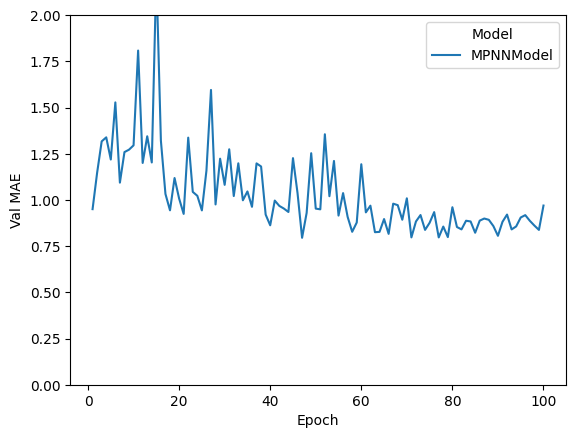

In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

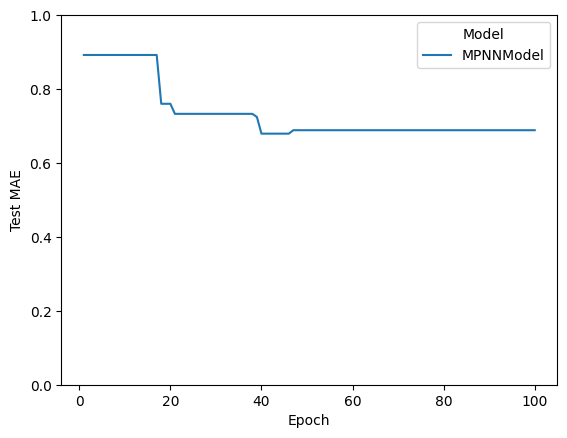

In [ ]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

In [ ]:
MolTo3DView(smi2conf(Chem.MolToSmiles(to_rdkit(train_dataset[48]))))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
class CoordMPNNModel(MPNNModel):
  def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
      """
      MPNN Model for graph property prediction

      This model uses both the node features like we had before but also the
      Geometric positions of the atoms in the molecule as an input variable.

      Args:
          num_layers: (int) --> number of message passing layers 'L'
          emb_dim: (int) --> hidden dimension 'd'
          in_dim: (int) --> initial dimension of node features 'd_n'
          edge_dim: (int) --> edge feature dimensions 'd_e'
          out_dim: (int) --> output dimension (fixed to 1)
      """
      super().__init__()

      self.lin_in= Linear(in_dim + 3, emb_dim) # (d_n + 3) --> d

      # Stacking MPNN Layers
      self.convs = torch.nn.ModuleList()
      for layer in range(num_layers):
        self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

      #Global pooling/readout function 'R' (mean pooling), done by PyG
      self.pool = global_mean_pool

      # Linear prediction head
      # dim: d -> out_dim
      self.lin_pred = Linear(emb_dim, out_dim)

  def forward(self, data):
      """
      Args:
          data: (PyG.Data) - batch of PyG graphs

      Returns:
          out: (batch_size, out_dim) --> prediction for each graph
      """
      combined_features = torch.cat([data.x, data.pos], dim=1)
      h = self.lin_in(combined_features) # (n, d_n + 3) --> (n, d)

      for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

      h_graph = self.pool(h, data.batch) # (n, d) --> (batch_size, d)

      out = self.lin_pred(h_graph) # (batch_size, d) --> (batch_size, 1)

      return out.view(-1)




In [ ]:
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name, # "MPNN w/ Features and Coordinates",
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)

Running experiment for CoordMPNNModel, training on 1000 samples for 100 epochs.

Model Architecture:
CoordMPNNModel(
  (lin_in): Linear(in_features=14, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 103425

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.2918021, Val MAE: 0.9396857, Test MAE: 0.8038028
Epoch: 020, LR: 0.000900, Loss: 0.2051185, Val MAE: 1.3225514, Test MAE: 0.7944283
Epoch: 030, LR: 0.000900, Loss: 0.1345287, Val MAE: 0.9538594, Test MAE: 0.6825143
Epoch: 040, LR: 0.000729, Loss: 0.0790667, Val MAE: 0.9047733, Test MAE: 0.6825143
Epoch: 050, LR: 0.000656, Loss: 0.0984284, Val MAE: 0.8878901, Test MAE: 0.6825143
Epoch: 060, LR: 0.000531, Loss: 0.0443942, Val MAE: 0.8349906, Test MAE: 0.6825143
Epoch: 070, LR: 0.000430, Loss: 0.0471165, Val MAE: 0.8764987, Test MAE: 0.6825143
Epoch: 080, LR: 0.000387, Loss: 0.0339622, Val MAE: 0.857

In [ ]:
RESULTS

{'MPNNModel': (0.7950816903114318, 0.6886202216148376, 2.0468157132466636),
 'CoordMPNNModel': (0.785898642539978, 0.6825142583847046, 2.522458263238271)}

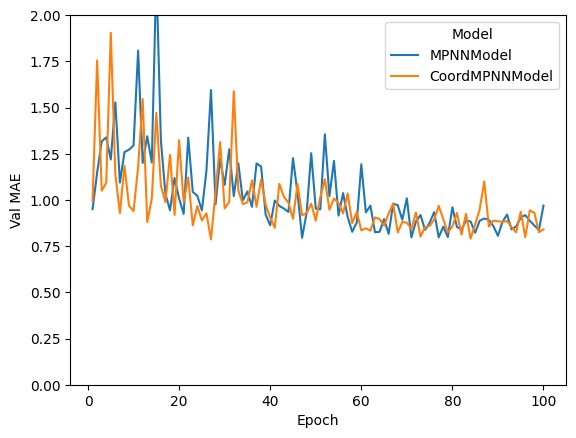

In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

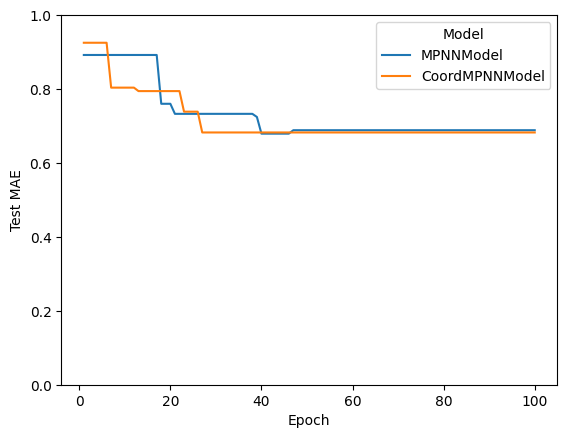

In [ ]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

In [ ]:
#@title 3D Rotations and Translation Invariance

def random_orthogonal_matrix(dim=3):
  """
  Helper function to build a random orthogonal matrix of shape (dim, dim)
  """
  Q = torch.tensor(ortho_group.rvs(dim=dim)).float()
  return Q


def rot_trans_invariance_unit_test(module, dataloader):
    """
    Unit test for checking whether a module (GNN model/layer) is
    rotation and translation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Forward pass on original example
    # Note: We have written a conditional forward pass so that the same unit
    #       test can be used for both the GNN model as well as the layer.
    #       The functionality for layers will be useful subsequently.
    if isinstance(module, MPNNModel):
        out_1 = module(data)
    else: # if ininstance(module, MessagePassing):
        out_1 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    Q = random_orthogonal_matrix(dim=3)
    t = torch.rand(3)

    data.pos = torch.matmul(data.pos, Q.T)
    data.pos = data.pos + t

    # Forward pass on rotated + translated example
    if isinstance(module, MPNNModel):
        out_2 = module(data)
    else: # if ininstance(module, MessagePassing):
        out_2 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    # Define a small epsilon for floating-point comparison
    epsilon = 1e-6

    # Use torch.allclose to compare tensors
    is_invariant = torch.allclose(out_1, out_2, rtol=epsilon, atol=epsilon)

    return is_invariant


In [ ]:
# Instantiate temporary model, layer, and dataloader for unit testing
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

Is CoordMPNNModel rotation and translation invariant? --> False!


In [ ]:
class InvariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is invariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # dims: (2d + d_e + 4) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 4, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )


    def forward(self, h, pos, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """

        out = self.propagate(edge_index, h=h, pos=pos, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, pos_i, pos_j, edge_attr):
      """The `message()` function constructs messages from source nodes j
          to destination nodes i for each edge (i, j) in `edge_index`.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            pos_i: (e, 3) - destination node positions
            pos_j: (e, 3) - source node positions
            edge_attr: (e, d_e) - edge features

        Returns:
          msg: (e, d) - messages `m_ij` passed through MLP `\psi`
      """
      rel_pos = pos_j - pos_i
      distance = torch.norm(rel_pos, dim=-1).unsqueeze(-1) # Add an extra dimension to distance
      msg = torch.cat([h_i, h_j,rel_pos, distance, edge_attr], dim=-1)
      return self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class InvariantMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of invariant MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(InvariantMPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.pos, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [ ]:
# Remember that we are now unit testing the InvariantMPNNModel,
# which is  composed of the InvariantMPNNLayer.
layer = InvariantMPNNLayer(emb_dim=64, edge_dim=4)
model = InvariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

# Rotation and translation invariance unit test for MPNN layer
print(f"Is {type(layer).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(layer, dataloader)}!")

Is InvariantMPNNModel rotation and translation invariant? --> False!
